In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from google.colab import files
import zipfile
import io
import os
import matplotlib.image as mpimg
import random
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!unzip -q "/content/gdrive/My Drive/dataset/newdata.zip"

replace data/train/bike/bike-1.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [0]:
!ls data/train

bike  car  motor  truck  van


In [0]:
batch_size = 32
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'data/train',  # This is the source directory for training images
        target_size=(200, 200),  # All images will be resized to 200 x 200
        batch_size=batch_size,
        # Specify the classes explicitly
        classes = ['bike','car','motor','truck','van'],
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical')

Found 2764 images belonging to 5 classes.


In [0]:


model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(200, 200, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 128 neuron in the fully-connected layer
    tf.keras.layers.Dense(128, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(5, activation='softmax')
])

In [0]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 198, 198, 16)      448       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 99, 99, 16)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 97, 97, 32)        4640      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 21, 21, 64)       

In [0]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [0]:
total_sample=train_generator.n

In [0]:
n_epochs = 30

In [0]:
history = model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_sample/batch_size),  
        epochs=n_epochs,
        verbose=1)

Epoch 1/30
86/86 [==============================] - 7s 76ms/step - loss: 1.4875 - acc: 0.3507
Epoch 2/30
86/86 [==============================] - 6s 70ms/step - loss: 1.1641 - acc: 0.5300
Epoch 3/30
86/86 [==============================] - 6s 69ms/step - loss: 1.0413 - acc: 0.5889
Epoch 4/30
86/86 [==============================] - 6s 68ms/step - loss: 0.9168 - acc: 0.6464
Epoch 5/30
86/86 [==============================] - 6s 68ms/step - loss: 0.8296 - acc: 0.6691
Epoch 6/30
86/86 [==============================] - 6s 68ms/step - loss: 0.7026 - acc: 0.7302
Epoch 7/30
86/86 [==============================] - 6s 68ms/step - loss: 0.6240 - acc: 0.7654
Epoch 8/30
86/86 [==============================] - 6s 68ms/step - loss: 0.5401 - acc: 0.7987
Epoch 9/30
86/86 [==============================] - 6s 68ms/step - loss: 0.4437 - acc: 0.8302
Epoch 10/30
86/86 [==============================] - 6s 68ms/step - loss: 0.3303 - acc: 0.8770
Epoch 11/30
86/86 [==============================] - 6s 67m

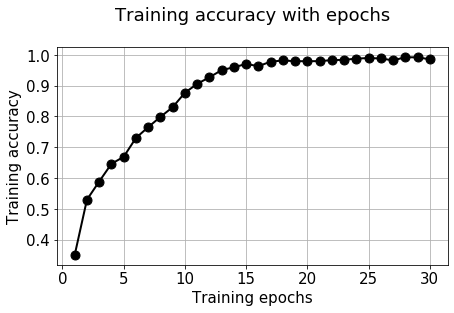

In [0]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(n_epochs)],history.history['acc'],'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training accuracy with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training accuracy",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

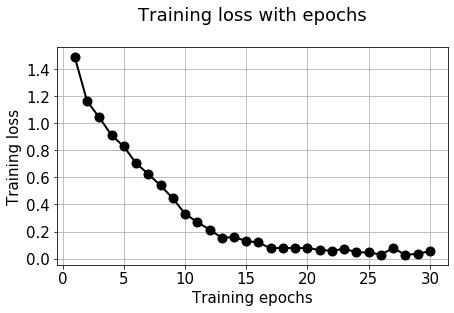

In [0]:
plt.figure(figsize=(7,4))
plt.plot([i+1 for i in range(n_epochs)],history.history['loss'],'-o',c='k',lw=2,markersize=9)
plt.grid(True)
plt.title("Training loss with epochs\n",fontsize=18)
plt.xlabel("Training epochs",fontsize=15)
plt.ylabel("Training loss",fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [0]:
def train_CNN(train_directory,target_size=(200,200), classes=None,
              batch_size=128,num_epochs=20,num_classes=5,verbose=0):
    """
    Trains a conv net for the flowers dataset with a 5-class classifiction output
    Also provides suitable arguments for extending it to other similar apps
    
    Arguments:
            train_directory: The directory where the training images are stored in separate folders.
                            These folders should be named as per the classes.
            target_size: Target size for the training images. A tuple e.g. (200,200)
            classes: A Python list with the classes 
            batch_size: Batch size for training
            num_epochs: Number of epochs for training
            num_classes: Number of output classes to consider
            verbose: Verbosity level of the training, passed on to the `fit_generator` method
    Returns:
            A trained conv net model
    
    """
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    import tensorflow as tf
    from tensorflow.keras.optimizers import RMSprop
    
    # ImageDataGenerator object instance with scaling
    train_datagen = ImageDataGenerator(rescale=1/255)

    # Flow training images in batches using the generator
    train_generator = train_datagen.flow_from_directory(
            train_directory,  # This is the source directory for training images
            target_size=target_size,  # All images will be resized to 200 x 200
            batch_size=batch_size,
            # Specify the classes explicitly
            classes = classes,
            # Since we use categorical_crossentropy loss, we need categorical labels
            class_mode='categorical')
    
    # ImageDataGenerator object instance with scaling
    val_datagen = ImageDataGenerator(rescale=1/255)
    # Flow training images in batches using the generator
    val_generator = val_datagen.flow_from_directory(
            "data/val/",  # This is the source directory for val images
            target_size=(200,200),  # All images will be resized to 200 x 200
            batch_size=128,
            # Specify the classes explicitly
            classes = ['bike','car','motor','truck','van'],
            # Since we use categorical_crossentropy loss, we need categorical labels
            class_mode='categorical')
    
    input_shape = tuple(list(target_size)+[3])
    
    # Model architecture
    model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 200x 200 with 3 bytes color
    # The first convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a dense layer
    tf.keras.layers.Flatten(),
    # 512 neuron in the fully-connected layer
    tf.keras.layers.Dense(512, activation='relu'),
    # 5 output neurons for 5 classes with the softmax activation
    tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    
    # Optimizer and compilation
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])
    
    # Total sample count
    total_sample=train_generator.n

    total_sample_val = val_generator.n
    
    # Training
    model.fit_generator(
        train_generator, 
        steps_per_epoch=int(total_sample/batch_size),  
        epochs=num_epochs,
        validation_data = val_generator,
        validation_steps = int(total_sample_val/batch_size)
        verbose=verbose)
    
    return model

In [0]:
train_directory = "data/train/"

In [0]:
trained_model=train_CNN(train_directory=train_directory,classes=['bike','car','motor','truck','van'],
                        num_epochs=30,num_classes=5,verbose=1)

Found 2764 images belonging to 5 classes.
Epoch 1/30
21/21 [==============================] - 6s 271ms/step - loss: 1.6214 - acc: 0.2883
Epoch 2/30
21/21 [==============================] - 5s 242ms/step - loss: 1.5572 - acc: 0.3312
Epoch 3/30
21/21 [==============================] - 5s 245ms/step - loss: 1.3295 - acc: 0.4636
Epoch 4/30
21/21 [==============================] - 5s 245ms/step - loss: 1.2279 - acc: 0.5144
Epoch 5/30
21/21 [==============================] - 5s 244ms/step - loss: 1.1135 - acc: 0.5383
Epoch 6/30
21/21 [==============================] - 5s 248ms/step - loss: 1.1004 - acc: 0.5606
Epoch 7/30
21/21 [==============================] - 5s 241ms/step - loss: 1.0130 - acc: 0.5909
Epoch 8/30
21/21 [==============================] - 5s 244ms/step - loss: 0.9354 - acc: 0.6294
Epoch 9/30
21/21 [==============================] - 5s 248ms/step - loss: 0.9022 - acc: 0.6473
Epoch 10/30
21/21 [==============================] - 5s 242ms/step - loss: 0.8215 - acc: 0.6741
Epoch 1

In [0]:
from PIL import Image
img_bike = Image.open('data/val/bike/bike-204.jpeg')
img_motor = Image.open('data/val/truck/truck-246.jpeg')

In [0]:
img_bike = img_bike.resize((200,200))
img_motor = img_motor.resize((200,200))

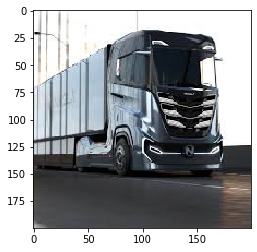

In [0]:
plt.imshow(img_motor)

In [0]:
import numpy as np
img_bike=np.expand_dims(img_bike, axis=0)
img_motor=np.expand_dims(img_motor, axis=0)

In [0]:
trained_model.predict(img_motor)

array([[0., 0., 0., 1., 0.]], dtype=float32)

In [0]:
!pip install -q pyyaml h5py

In [0]:
model.save('firstmodel.h5')

In [0]:
!ls

data  firstmodel.h5  gdrive  sample_data


In [0]:
from google.colab import files
f = 'firstmodel.h5'
files.download(f)